# EECS 504 Homework 2

## Problem 3: Representation Learning

In this assignment, you'll implement an autoencoder and train it on the STL-10 dataset.

### Getting Started
Make your own copy of this notebook using **File -> Save a copy in Drive**, or if you have iPython installed locally, **File -> Download .ipynb** to do the exercises locally.

### Submitting
When you're ready to submit this problem, first run all of the code to ensure your outputs are included in the submission. Save the `.ipynb` file and submit it to Canvas as `HW2.3_<uniqname>.ipynb`, substituting your uniqname. Be sure your name, uniqname, and UMID are correct in the form fields below. 

**We would also want you to include a pdf version of your final notebook with outputs in your canvas submission, alongwith .ipynb file. You can follow these steps to save a pdf version. After completing your code and running all cells to include output, you can go to File -> Print -> Save as pdf and choose Landscape mode in Colab. Naming convention is same as that for .ipynb file.**

# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

In [ ]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms

from torchsummary import summary
import tqdm

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101
Using the GPU!


# Self-supervised learning

In this problem, we are going to implement a representation learning method: an autoencoder and implement a denoising autoencoder that overcomes the drawbacks of traditional autoencoders.  


# Downloading the dataset.

We use PyTorch built-in class to download  the STL-10 (http://ai.stanford.edu/~acoates/stl10/) dataset (a subset of ImageNet). The STL-10 dataset contains three partitions: train, test, and unlabeled. The train partition contains 10 image classes, each class with 500 images. The test partition contains 800 images for each class. The unlabeled contains a total of 100,000 images with many classes not in the train/test partitions.

In [ ]:
unlabeled_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomCrop(64),
                                         transforms.ToTensor()])

labeled_transform = transforms.Compose([transforms.CenterCrop(64),
                                        transforms.ToTensor()])


# We use the PyTorch built-in class to download the STL-10 dataset.
# The 'unlabeled' partition contains 100,000 images without labels.
# It's used for leanring representations with unsupervised learning. 
dataset_un = torchvision.datasets.STL10('./data', 'unlabeled', download=True, transform=unlabeled_transform)

dataset_tr = torchvision.datasets.STL10('./data', 'train', download=False, transform=labeled_transform)
dataset_te = torchvision.datasets.STL10('./data', 'test', download=False, transform=labeled_transform)


Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
print('# of samples for ulabeled, train, and test, {}, {}, {}'.format(len(dataset_un), len(dataset_tr), len(dataset_te)))
print('Classes in train: {}'.format(dataset_tr.classes))

# of samples for ulabeled, train, and test, 100000, 5000, 8000
Classes in train: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


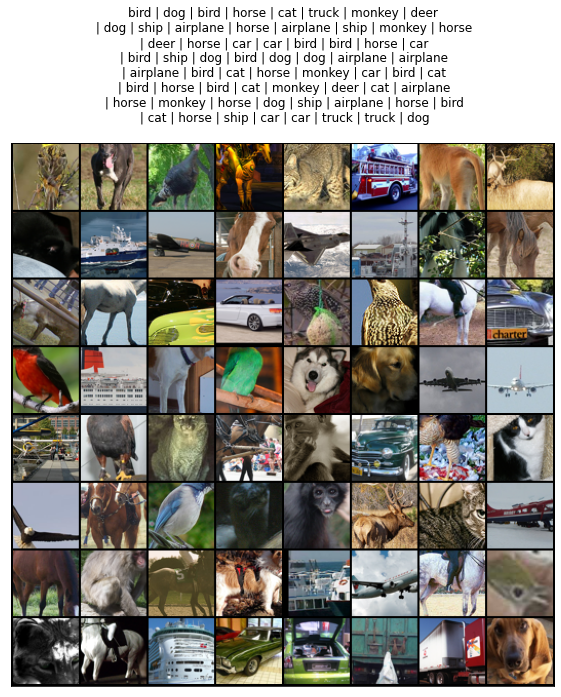

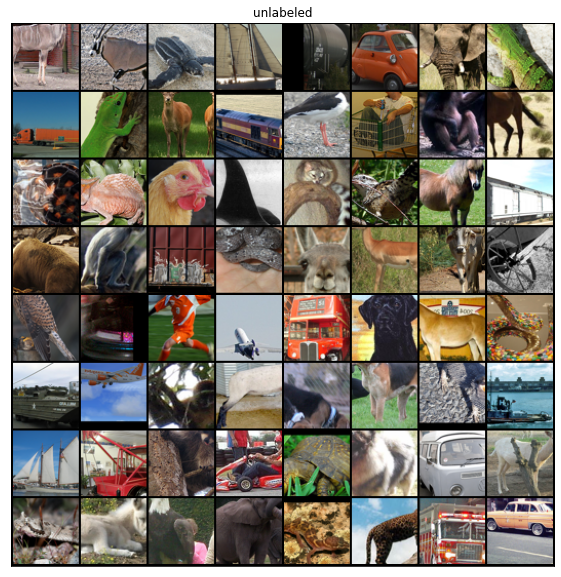

In [ ]:
# Visualize the data within the dataset
class_names = dict(zip(range(10), dataset_tr.classes))
dataloader_un = DataLoader(dataset_un, batch_size=64)
dataloader_tr = DataLoader(dataset_tr, batch_size=64)

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Visualize training partition
# Get a batch of training data
inputs, classes = next(iter(dataloader_tr))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 8 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

# Visualize unlabeled partition
inputs, classes = next(iter(dataloader_un))
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title='unlabeled', ax=ax)

As can be seen from above visualizations, the unlabeled partition contains classes that are not in the training partition. Though not labeled, the unlabeled partition has much more data than the labeled training partition. The large amount of unlabeled label ought to help us learn useful representations. In the next sections, we will use the unlabeled partition to help learn representations that is helpful for downstream tasks.

# Part 1. Autoencoders

We will first build an autoencoder. To keep training time low, we'll use a very simple network structure.

## 1.1 Build the encoder
Please make sure that your encoder has the same architeture as we print below before your proceed to the decoder part. All conv layers have a bias term and a square kernel (k-by-k). You can solve for the kernel size, stride, and padding using the equation for convolution input/output sizes:

$$ H_{in} + 2\cdot padding - (H_{kernel} - 1) + 1 = stride * H_{out}$$

and the equation for the number of parameters in a convolutional layer:

$$ \#\{params\} = C_{in} \cdot C_{out} \cdot (H_{kernel})^2 + C_{bias} $$

where $C_{bias} = C_{out}$.

Note: Define `self.encoder` as an `nn.Sequential` module containing each layer in order if you want your output to look identical to the summary below. You can do the same thing with the decoder module in the next section.

### Encoder archiecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #  
            Conv2d-1           [-1, 12, 32, 32]             588  
              ReLU-2           [-1, 12, 32, 32]               0  
            Conv2d-3           [-1, 24, 16, 16]           4,632  
              ReLU-4           [-1, 24, 16, 16]               0  
            Conv2d-5             [-1, 48, 8, 8]          18,480  
              ReLU-6             [-1, 48, 8, 8]               0   
            Conv2d-7             [-1, 24, 4, 4]          18,456  
              ReLU-8             [-1, 24, 4, 4]               0  
Total params: 42,156  
Trainable params: 42,156  
Non-trainable params: 0  
Input size (MB): 0.05
Forward/backward pass size (MB): 0.33  
Params size (MB): 0.16  
Estimated Total Size (MB): 0.54  

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super(Encoder, self).__init__()

        ##############################################################################
        # TODO: Build an encoder with the architecture as specified above.#
        ##############################################################################
        layers = []
        layers.extend([nn.Conv2d(3,12, kernel_size=4, padding=1, stride = 2), nn.ReLU(True)])
        layers.extend([nn.Conv2d(12,24, kernel_size = 4, padding = 1, stride = 2), nn.ReLU(True)])
        layers.extend([nn.Conv2d(24,48, kernel_size = 4, padding = 1, stride = 2), nn.ReLU(True)])
        layers.extend([nn.Conv2d(48,24, kernel_size = 4, padding = 1, stride = 2), nn.ReLU(True)])
        self.encoder = nn.Sequential(*layers)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, x):
        '''
        Given an image x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            h: torch.tensor
        '''
        
        h = self.encoder(x)

        return h

In [ ]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
encoder = Encoder().to(device)
summary(encoder, [(3, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             588
              ReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 24, 16, 16]           4,632
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 48, 8, 8]          18,480
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 24, 4, 4]          18,456
              ReLU-8             [-1, 24, 4, 4]               0
Total params: 42,156
Trainable params: 42,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.33
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
----------------------------------------------------------------


## 1.2 Build the decoder

Next, we build the decoder to reconstruct the image from the latent representation extracted by the encoder. Please implement the decoder following the architecture printed here. 

Note: The `ConvTranspose2d` class is very similar to the `Conv2d` class. It is designed for the express purpose of "reversing" or "deconvolving" a `Conv2d` layer with the same parameters. The `padding`, `stride`, and `bias` arguments to `ConvTranspose2d` will be the same as the ones you provided to the corresponding `Conv2d` layer. For example, `ConvTranspose2d-1` should match up with `Conv2d-7` from the encoder, `ConvTranspose2d-3` matches with `Conv2d-5`, etc.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #  
              ConvTranspose2d-1   [-1, 48, 8, 8]         18,480  
              ReLU-2              [-1, 48, 8, 8]              0  
              ConvTranspose2d-3   [-1, 24, 16, 16]       18,456  
              ReLU-4              [-1, 24, 16, 16]            0
              ConvTranspose2d-5   [-1, 12, 32, 32]        4,620  
              ReLU-6              [-1, 12, 32, 32]            0  
              ConvTranspose2d-7   [-1, 3, 64, 64]           579  
              Sigmoid-8           [-1, 3, 64, 64]             0  

Total params: 42,135  
Trainable params: 42,135  
Non-trainable params: 0  
Input size (MB): 0.00  
Forward/backward pass size (MB): 0.52  
Params size (MB): 0.16  
Estimated Total Size (MB): 0.68  

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels=3, feat_dim=64):
        super(Decoder, self).__init__()

        ##############################################################################
        # TODO: Build the decoder as specified above.                                #
        ##############################################################################
        layers = []
        layers.extend([nn.ConvTranspose2d(24,48, kernel_size=4, padding=1, stride = 2), nn.ReLU(True)])
        layers.extend([nn.ConvTranspose2d(48,24, kernel_size = 4, padding = 1, stride = 2), nn.ReLU(True)])
        layers.extend([nn.ConvTranspose2d(24,12, kernel_size = 4, padding = 1, stride = 2), nn.ReLU(True)])
        layers.extend([nn.ConvTranspose2d(12,3, kernel_size = 4, padding = 1, stride = 2), nn.ReLU(True)])
        self.decoder = nn.Sequential(*layers)
        

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, h):
        '''
        Given latent representation h, reconstruct an image patch of size 64 x 64.

        Args:
            h: torch.tensor

        Return: 
            x: torch.tensor
        '''
        x = self.decoder(h)
        return x

In [ ]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
decoder = Decoder().to(device)
summary(decoder, [(24, 4, 4)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 48, 8, 8]          18,480
              ReLU-2             [-1, 48, 8, 8]               0
   ConvTranspose2d-3           [-1, 24, 16, 16]          18,456
              ReLU-4           [-1, 24, 16, 16]               0
   ConvTranspose2d-5           [-1, 12, 32, 32]           4,620
              ReLU-6           [-1, 12, 32, 32]               0
   ConvTranspose2d-7            [-1, 3, 64, 64]             579
              ReLU-8            [-1, 3, 64, 64]               0
Total params: 42,135
Trainable params: 42,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.16
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


## 1.3 Put together the autoencoder

Now we have the encoder and the decoder classes. We only need to implement another `Autoencoder` class to wrap the encoder and the decoder together.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x)
        x_ = self.decoder(h)

        return x_

In [ ]:
# verify that your aueconder's output size is 3 x 64 x 64 
ae = Autoencoder().to(device)
summary(ae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             588
              ReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 24, 16, 16]           4,632
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 48, 8, 8]          18,480
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 24, 4, 4]          18,456
              ReLU-8             [-1, 24, 4, 4]               0
           Encoder-9             [-1, 24, 4, 4]               0
  ConvTranspose2d-10             [-1, 48, 8, 8]          18,480
             ReLU-11             [-1, 48, 8, 8]               0
  ConvTranspose2d-12           [-1, 24, 16, 16]          18,456
             ReLU-13           [-1, 24, 16, 16]               0
  ConvTranspose2d-14           [-1, 12,

## 1.4 Training the autoencoder

Now, we'll train the autoencoder to reconstruct images from the unlabeled set of STL-10. Note that the reconstructed images will contain significant artifacts, due to the limited size of the bottleneck between the encoder and decoder, and the small network size.

In [ ]:
# We train on 10,000 unsupervised sampels instead of 100,000 samples to speed up training
n = 10000
dataset_un_subset, _ = torch.utils.data.random_split(dataset_un, [n,100000-n])
dataloader_un = DataLoader(dataset_un_subset, batch_size=128, shuffle=True)
dataloader_tr = DataLoader(dataset_tr, batch_size=128, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=128, shuffle=False)

In [ ]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()
    img = next(iter(dataloader))[0][:8].to(device)
    out = model(img)

    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    inp = torchvision.utils.make_grid(torch.cat((img, out), dim=2), nrow=8)
    imshow(inp.detach().cpu(), ax=ax)
    model.train()
    plt.show()

In [ ]:
def train_ae(model, dataloader, epochs=200):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm.notebook.tqdm(range(epochs)):

        loss_epoch = 0
        for x, _ in dataloader:
            x = x.to(device)
            ##############################################################################
            # TODO: Train the autoencoder on one minibatch.                              #
            # Warning - Remember to zero the gradients.
            ##############################################################################
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, x)
            result = torch.max(outputs, 1)
            preds = result[1]
            loss.backward()
            optimizer.step()
            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            visualize_recon(model, dataloader)

    return model, loss_traj

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0, loss 7.646


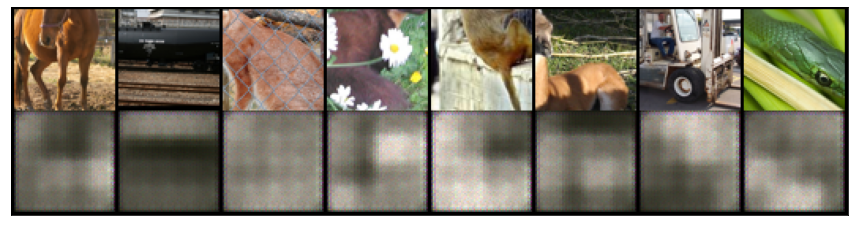

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 10, loss 1.224


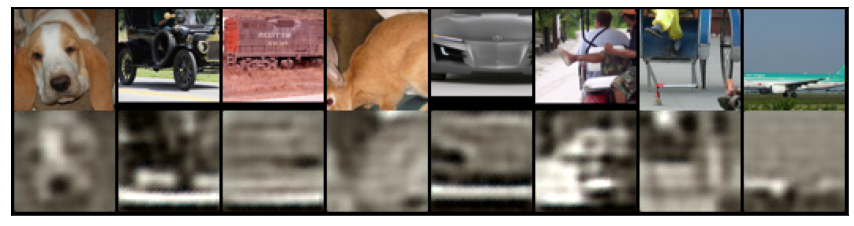

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20, loss 0.848


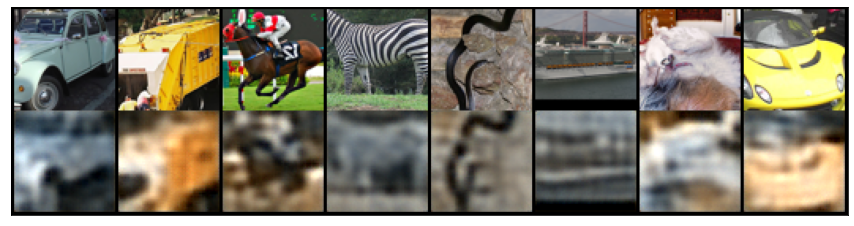

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 30, loss 0.774


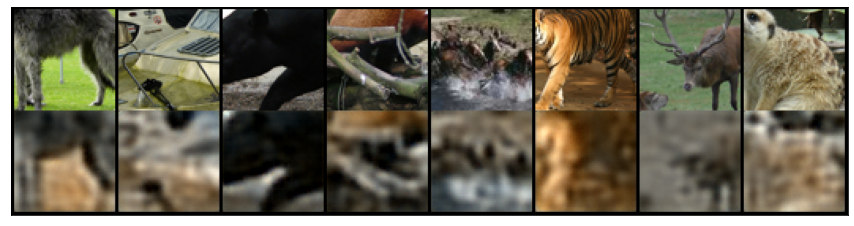

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40, loss 0.713


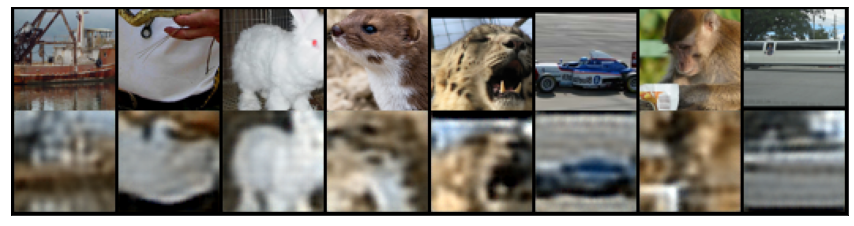

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50, loss 0.665


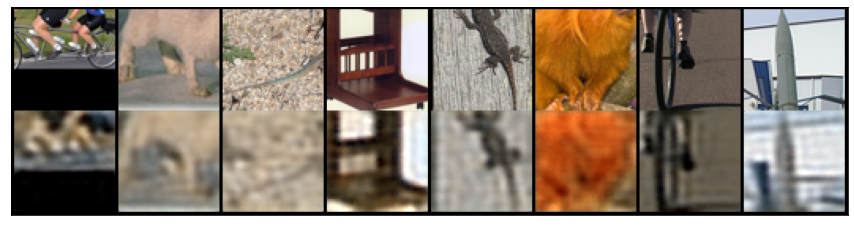

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60, loss 0.635


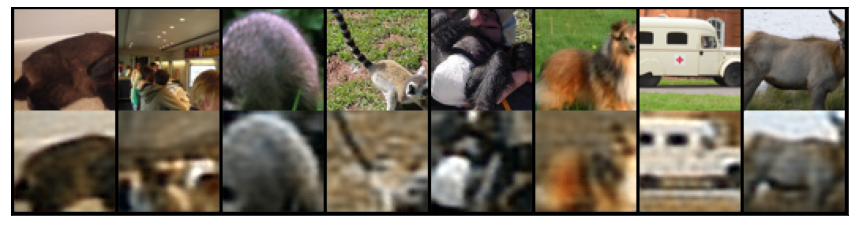

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 70, loss 0.640


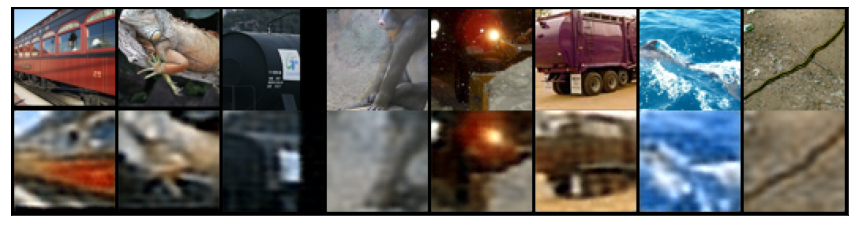

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80, loss 0.607


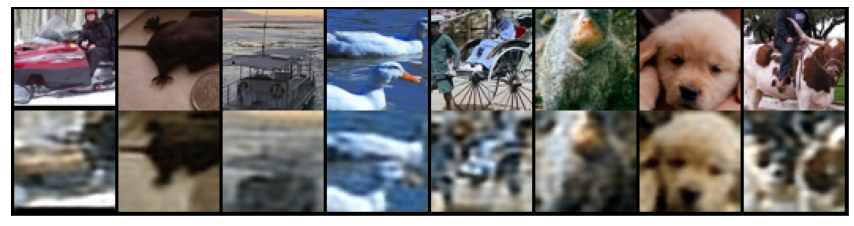

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 90, loss 0.592


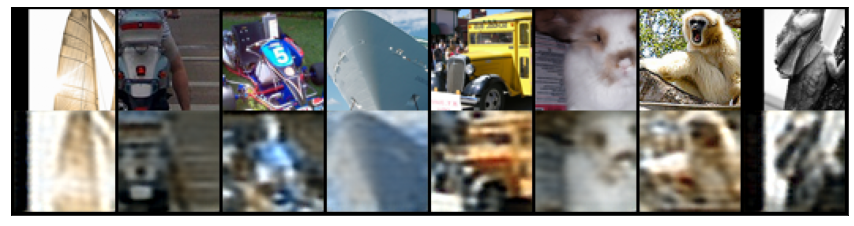

In [ ]:
# Train the autoencoder for 100 epochs
ae = Autoencoder().to(device)
ae, ae_loss_traj = train_ae(ae, dataloader_un, epochs=100)
torch.save(ae.state_dict(), 'ae.pth')

After training the autoencoder on the 100,000 images for 100 epochs, we see that autoencoder has leanred to approximately recontruct the image.

## 1.5 Train a linear classifier

Now, we ask how useful the features are for object recongition. We'll train a linear clasifier that takes the output of the encoder as its features. During training, we freeze the parameters of the encoder. To verify the effectiveness of unsupervised pretraining, we compare the linear classifier accuracy against two baselines:

* Supervised: train the encoder together with the linear classifier on the training set for 100 epochs. 
* Random weights: freeze the parameters of a randomly initialized encoder during training. 

In [ ]:
# latent representation dimension (the output dimension of the encoder)
feat_dim = 24 * 4 * 4

In [ ]:
def train_classfier(encoder, cls, dataloader, epochs=100, supervised=False):
    '''
    Args:
        encoder: trained/untrained encoder for unsupervised/superved training.
        cls: linear clssifier.
        dataloader: train partition.
        supervised: whether or not to update the encoder weights

    Return:
        cls: linear clssifier.
    '''

    optimizer = optim.Adam(cls.parameters(), lr=0.001, weight_decay=1e-4)
    if supervised:
        optimizer = optim.Adam(list(cls.parameters())+list(encoder.parameters()), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    loss_traj = []
    accuracy_traj = []

    for epoch in tqdm.notebook.tqdm(range(epochs)):

        loss_epoch = 0
        corrects_epoch = 0
        for x, y in dataloader:

            batch_size = x.size(0)
            x = x.float()
            x,y = x.to(device), y.to(device)

            ##############################################################################
            # TODO: update the parameters of the classifer. If in supervised mode, the   #
            # parameter of the encoder is also updated.                                  #
            ##############################################################################
            optimizer.zero_grad()
            x_encoded = encoder.forward(x)
            x_encoded = x_encoded.reshape(x_encoded.shape[0], -1)
            outs = cls(x_encoded)
            loss = criterion(outs, y)
            loss.backward()
            optimizer.step()
            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            _, preds = torch.max(outs, 1)
            corrects_epoch += torch.sum(preds == y.data)
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        epoch_acc = corrects_epoch.double() / len(dataloader.dataset)
        accuracy_traj.append(epoch_acc)
    
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}, train accuracy {}'.format(epoch, loss_epoch, epoch_acc))

    return cls, loss_traj

In [ ]:
def test(encoder, cls, dataloader):
    '''
    Calculate the accuracy of the trained linear classifier on the test set.
    '''
    cls.eval()

    loss_epoch = 0
    corrects_epoch = 0
    for x, y in dataloader:
        
        x = x.float()
        batch_size = x.size(0)
        x, y = x.to(device), y.to(device)
        h = encoder(x).view(batch_size, -1)
        outs = cls(h)
        _, preds = torch.max(outs, 1)
        corrects_epoch += torch.sum(preds == y.data)

    epoch_acc = corrects_epoch.double() / len(dataloader.dataset)
    print('Test accuracy {}'.format(epoch_acc))

In [ ]:
# Method I: unsupervised pretraining + training linear classifier
# Freeze the parameters of the trained autoencoder
# Train a linear classifier using the features 
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
cls_unsupervised, loss_traj_unsupervised = train_classfier(ae.encoder, linear_cls, dataloader_tr, epochs=100)
test(ae.encoder, cls_unsupervised, dataloader_te)

Epoch 0, loss 96.219, train accuracy 0.16340000000000002
Epoch 10, loss 80.962, train accuracy 0.2718
Epoch 20, loss 76.603, train accuracy 0.32480000000000003
Epoch 30, loss 76.362, train accuracy 0.32880000000000004
Epoch 40, loss 73.672, train accuracy 0.3546
Epoch 50, loss 72.105, train accuracy 0.369
Epoch 60, loss 71.946, train accuracy 0.3688
Epoch 70, loss 70.626, train accuracy 0.382
Epoch 80, loss 70.594, train accuracy 0.3824
Epoch 90, loss 70.956, train accuracy 0.3748

Test accuracy 0.27087500000000003


In [ ]:
# Method II: supervised training
# Train the encoder together with the linear classifier
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
encoder = Autoencoder().to(device).encoder
cls_supervised, loss_traj_supervised = train_classfier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=True)
test(encoder, cls_supervised, dataloader_te)

Epoch 0, loss 87.470, train accuracy 0.161
Epoch 10, loss 59.304, train accuracy 0.4556
Epoch 20, loss 50.531, train accuracy 0.5278
Epoch 30, loss 45.551, train accuracy 0.5966
Epoch 40, loss 36.731, train accuracy 0.673
Epoch 50, loss 27.371, train accuracy 0.765
Epoch 60, loss 19.260, train accuracy 0.8378
Epoch 70, loss 14.326, train accuracy 0.8766
Epoch 80, loss 5.688, train accuracy 0.9604
Epoch 90, loss 6.418, train accuracy 0.9478000000000001

Test accuracy 0.425375


In [ ]:
# Method III: random encoder + training linear classifier
# We freeze the parameters of the randomly initialized encoder during training
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
encoder = Autoencoder().to(device).encoder
cls_random, loss_traj_random = train_classfier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=False)
test(encoder, cls_random, dataloader_te)

Epoch 0, loss 92.124, train accuracy 0.09820000000000001
Epoch 10, loss 91.954, train accuracy 0.13520000000000001
Epoch 20, loss 91.843, train accuracy 0.17300000000000001
Epoch 30, loss 91.716, train accuracy 0.19260000000000002
Epoch 40, loss 91.629, train accuracy 0.1836
Epoch 50, loss 91.548, train accuracy 0.2398
Epoch 60, loss 91.470, train accuracy 0.185
Epoch 70, loss 91.413, train accuracy 0.1932
Epoch 80, loss 91.358, train accuracy 0.2142
Epoch 90, loss 91.304, train accuracy 0.2182

Test accuracy 0.233375


With pretrained encoder, the linear classifier should achieve about 30% accuracy on the test set. With the supervised approach, the linear classifier should achieve an accuracy above 40%. The random encoder approach performs the worst among these three. The observation that the pretrained encoder outperforms the random encoder confirms that unsupervised pretraining has learnt a useful represenation. However, the quality of this learned representation is not good because it only performs slightly better than the random encoder. In the next part, we'll modify the autoencoder to be a denoising autoencoder and compare its performance to the above models.

# Part 2. Denoising Autoencoders

One way to boost the performance of an autoencoder is to add noise to the input. This forces the model to attend to the important pieces of the image, rather than match every pixel equally. In the cells below, implement a denoising version of the autoencoder from above, using Gaussian noise.

In [32]:
rng = np.random.default_rng()

class DenoisingAutoencoder(Autoencoder):
  def __init__(self, in_channels=3, feat_dim=64, sigma=1):
    super(DenoisingAutoencoder, self).__init__(in_channels, feat_dim)
    self.sigma = sigma
  
  def forward(self, x):
    ##############################################################################
    # TODO: Add Gaussian noise (mean 0.0, variance = self.sigma) to x before     #
    # passing it to the Autoencoder's forward function. Hint: You'll need to     #
    # make a Tensor object for the noise before adding it to x. Don't forget to  #
    # move it to the GPU before using it.                                        #
    ##############################################################################
    
    x_noise = None
    noise = np.random.normal(0, self.sigma, size = x.shape)
    noise = torch.from_numpy(noise)
    noise = noise.float()
    noise = noise.to(device)
    x = x.float()
    x = x.to(device)
    x_noise = noise + x
    x_noise = x_noise.to(device)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return super(DenoisingAutoencoder, self).forward(x_noise)

## 2.1 Training the denoising autoencoder
Train the autoencoder for 100 epochs.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 0, loss 8.612


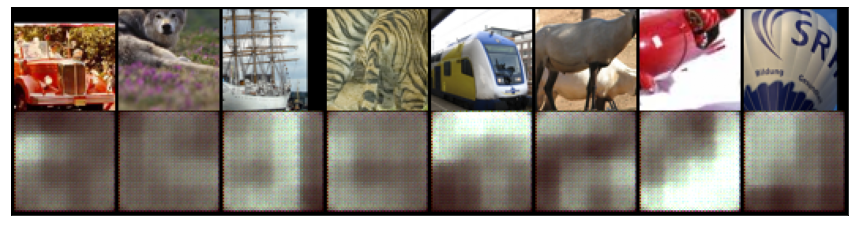

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 10, loss 1.662


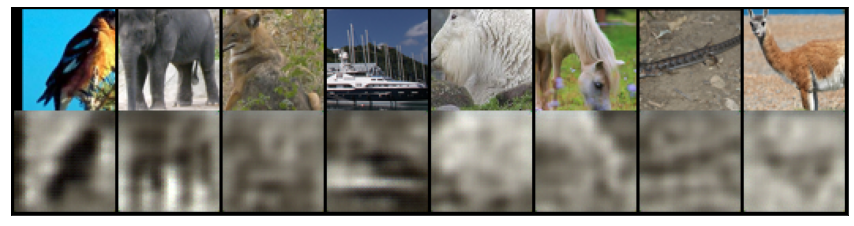

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20, loss 1.370


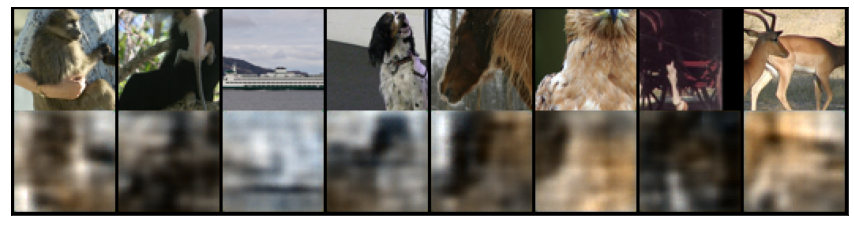

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 30, loss 1.306


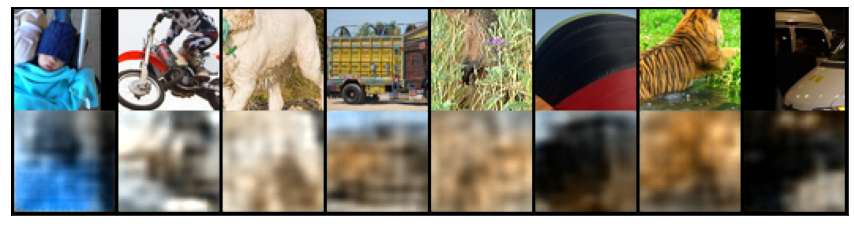

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40, loss 1.286


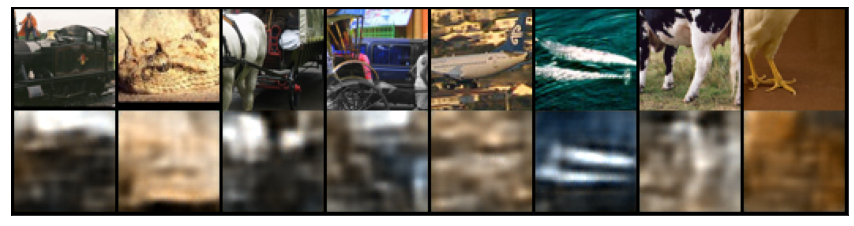

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 50, loss 1.262


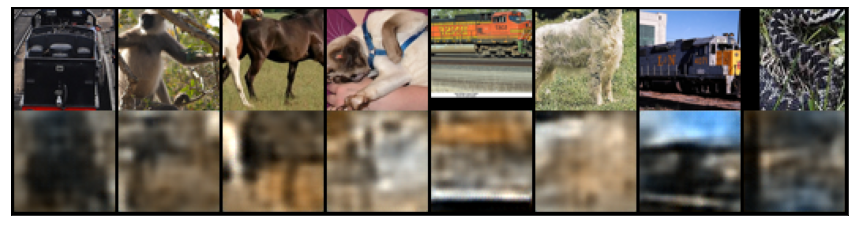

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60, loss 1.236


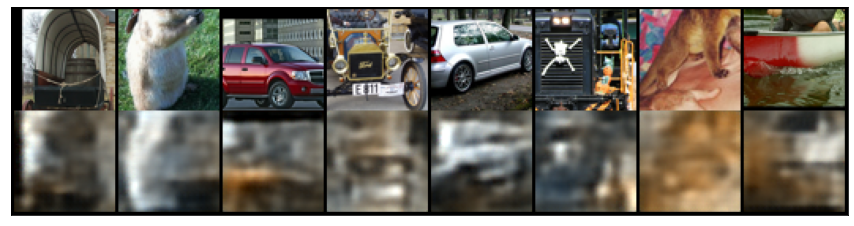

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 70, loss 1.227


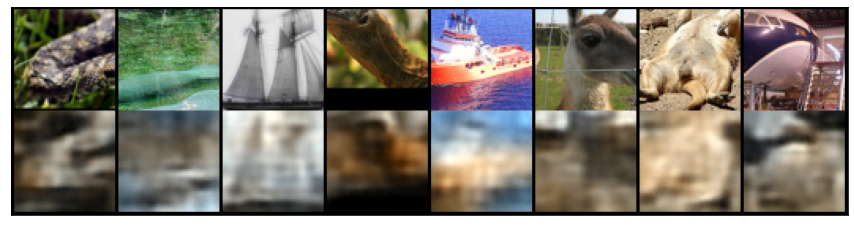

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80, loss 1.215


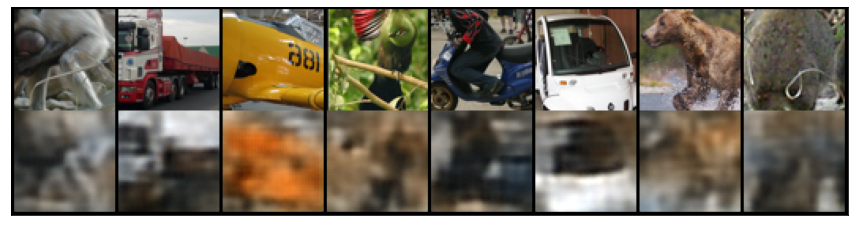

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 90, loss 1.207


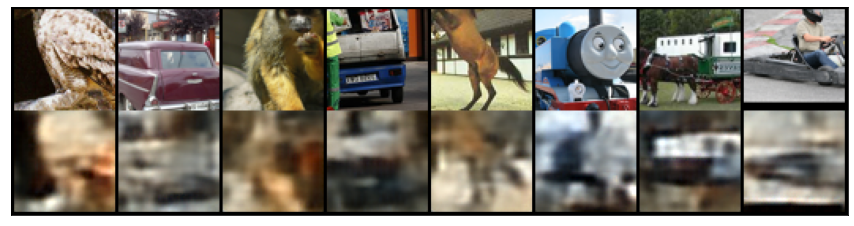

In [33]:
dae = DenoisingAutoencoder().to(device)
dae, dae_loss_traj = train_ae(dae, dataloader_un, epochs=100)
torch.save(dae.state_dict(), 'dae.pth')

### 2.2 Train a linear classifier

Repeat the experiment from above.

In [34]:
# Method IV: denoising + unsupervised pretraining + training linear classifier
# Freeze the parameters of the trained autoencoder
# Train a linear classifier using the features 
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
cls_unsupervised, loss_traj_unsupervised = train_classfier(dae.encoder, linear_cls, dataloader_tr, epochs=100)
test(dae.encoder, cls_unsupervised, dataloader_te)

Epoch 0, loss 97.471, train accuracy 0.1474
Epoch 10, loss 68.470, train accuracy 0.391
Epoch 20, loss 65.433, train accuracy 0.41800000000000004
Epoch 30, loss 64.409, train accuracy 0.4334
Epoch 40, loss 62.587, train accuracy 0.45120000000000005
Epoch 50, loss 62.033, train accuracy 0.45020000000000004
Epoch 60, loss 61.345, train accuracy 0.456
Epoch 70, loss 60.125, train accuracy 0.468
Epoch 80, loss 60.966, train accuracy 0.466
Epoch 90, loss 59.757, train accuracy 0.46580000000000005

Test accuracy 0.37775000000000003
